In [ ]:
import math

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def read_gff(path_to_file):
    col_names = ["chromosome", "source", "type", "start", "end", "score", "strand", "phase", "attributes"]
    gff_file = pd.read_csv(path_to_file, sep='\t', header=None, comment="#")
    gff_file.columns = col_names
    return gff_file


annotation = read_gff("rrna_annotation.gff")
annotation

In [ ]:
def read_bed6(path_to_file):
    col_names = ["chromosome", "start", "end", "name", "score", "strand"]
    bed_file = pd.read_csv(path_to_file, sep='\t', header=None, comment="#")
    bed_file.columns = col_names
    return bed_file


alignment = read_bed6("alignment.bed")
alignment

In [ ]:
def filter_attributes(df):
    df['attributes'].replace(r'Name=(\d+\w)_rRNA;product=(\d+\w)\s.+', r'\2', regex=True, inplace=True)
    return df


annotation = filter_attributes(annotation)
annotation

In [ ]:
annotation = annotation.sort_values(by=['chromosome'])

sns.countplot(data=annotation, x='chromosome', hue='attributes')
plt.xticks(rotation=90)
plt.tight_layout()

In [ ]:
merged = annotation.merge(alignment, left_on='chromosome', right_on='chromosome')

merged[(merged.start_x >= merged.start_y) & (merged.end_x <= merged.end_y)]

In [ ]:
def read_volcano_data(path_to_file):
    data = pd.read_csv(path_to_file, sep='\t', comment="#")
    return data


volcano_data = read_volcano_data("diffexpr_data.tsv.gz")
volcano_data

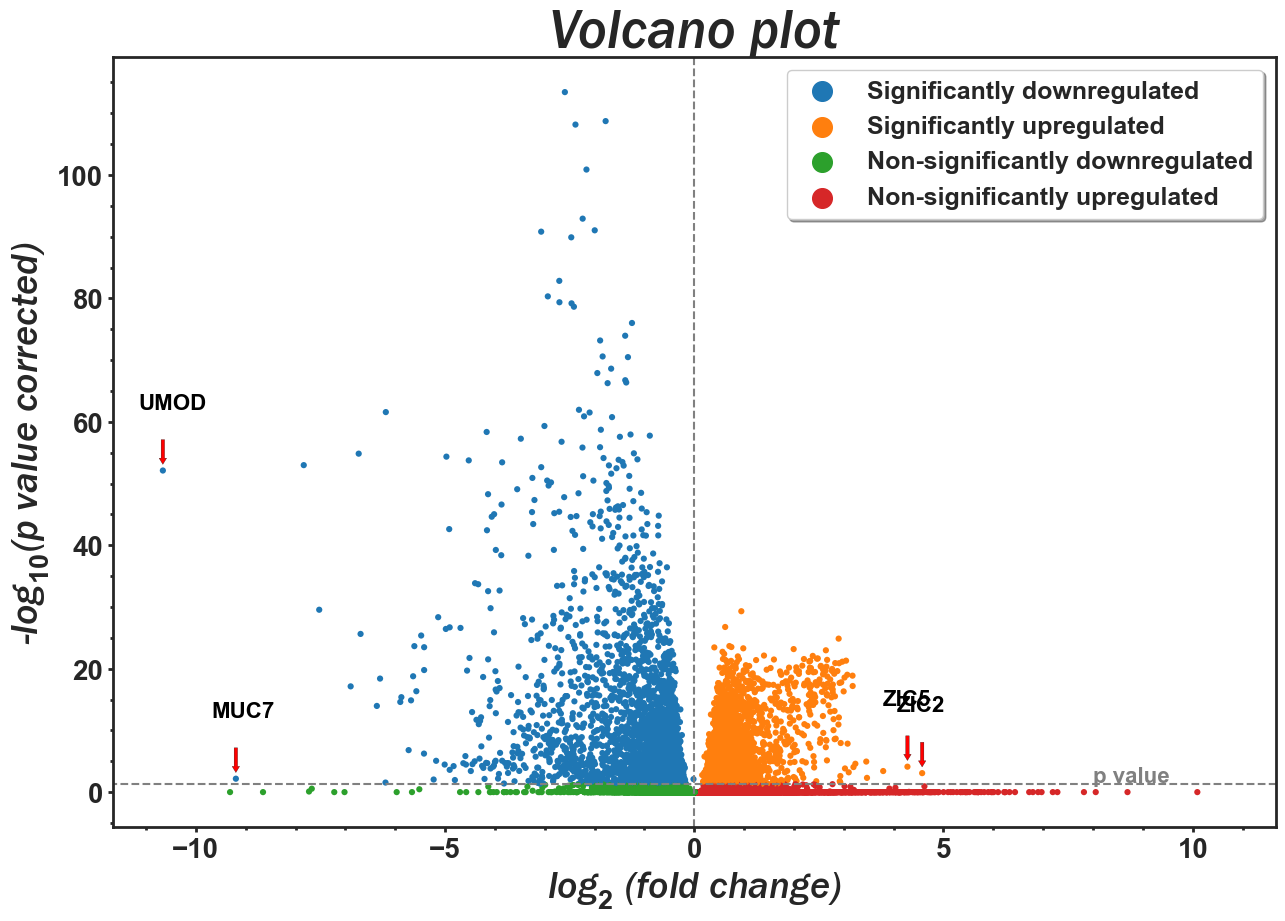

In [126]:
def get_color(x, y, threshold):
    if x <= 0 and y >= threshold:
        return 1
    elif x >= 0 and y >= threshold:
        return 2
    elif x <= 0 and y <= threshold:
        return 3
    return 4


threshold = -math.log10(0.05)
volcano_data['group'] = volcano_data.apply(lambda x: get_color(x['logFC'], x['log_pval'], threshold), axis=1)
top_down = volcano_data.query('group == 1').sort_values(by='logFC').head(2)
top_up = volcano_data.query('group == 2').sort_values(by='logFC').tail(2)
top = pd.concat([top_down, top_up])

plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['figure.figsize'] = 15,10
plt.rcParams['font.weight'] = 'bold'
font = {'fontname':'Franklin Gothic Medium'}

sns.set_style("ticks")
volcano = sns.scatterplot(x='logFC', y='log_pval', hue= 'group', s=20, palette="tab10", linewidth=0, data=volcano_data)

#add gray lines
plt.axvline(ymax=120, color='grey', linestyle='--')
plt.axhline(y=-math.log10(0.05), xmin=-20, xmax=20, color='grey', linestyle='--')

#add p-value text
plt.text(8, 1.6, "p value", horizontalalignment='left', size=16, color='grey', weight='bold')

#Change labels
volcano.set_title('Volcano plot', style='italic', fontsize=40, **font)
volcano.set_xlabel(r'log$\mathbf{_2}$ (fold change)', style='italic', fontsize=28, **font)
volcano.set_ylabel(r'-log$\mathbf{_{10}}$(p value corrected)', style='italic', fontsize=28, **font)

#Change ticks
volcano.set_xticks(range(-11, 12), minor=True)
volcano.set_yticks(range(-5, 116, 5), minor=True)
volcano.tick_params(width=2, which='both')
for _,s in volcano.spines.items():
    s.set_linewidth(2)

#Set bounds
bound = max(abs(min(volcano_data['logFC'])), abs(max(volcano_data['logFC']))) + 1
plt.xlim(-bound, bound)

#Change legend
volcano.legend(fontsize=18, shadow = True)
new_legend = ['Significantly downregulated', 'Significantly upregulated', 'Non-significantly downregulated', 'Non-significantly upregulated']
leg = volcano.get_legend()
for t, l in zip(leg.texts, new_legend):
    t.set_text(l)
for lh in volcano.legend_.legendHandles:
    lh._sizes = [200]

#Add text and arrows
for i in range(top.shape[0]):
    plt.text(top.iloc[i, 1] - 0.5, top.iloc[i, 4] + 10, top.iloc[i, 0], horizontalalignment='left', size=16, color='black', weight='bold')
    plt.arrow(top.iloc[i, 1], top.iloc[i, 4] + 5, dx=0, dy=-3, head_width=0.15, head_length=1, width=0.07, linewidth=0.2, fc='r', ec='k')

plt.show()